## Código para Generación de Tripletas a partir de los datos extraídos


1. **`clean_for_uri`**:
   - Función diseñada para normalizar cadenas de texto y transformarlas en un formato apto para URIs.
   - Realiza transliteración básica, elimina caracteres no permitidos y convierte el texto a minúsculas.
   - Limita la longitud máxima a 100 caracteres para mantener consistencia.

2. **Namespaces y `Graph`**:
   - Define un grafo RDF utilizando la librería `rdflib`.
   - Vincula múltiples namespaces conocidos como `schema`, `dbp`, y `skos`, además de un namespace personalizado `myv`.
   - Los namespaces facilitan la creación de URIs estandarizadas en el grafo RDF.

3. **Carga de datos**:
   - Utiliza `pandas` para cargar datos estructurados desde archivos CSV.
   - Cada archivo CSV representa un conjunto diferente de datos:
     - `citations.csv`: Contiene información sobre citas entre artículos (DOIs, referencias).
     - `scopus_detailed_papers.csv`: Papers extraídos con abstract y journals.
     - `scopus_papers.csv`: Información básica de los artículos.

In [2]:
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD, SKOS, DCTERMS
import pandas as pd
import re

# Helper function to clean and format strings for URIs
def clean_for_uri(text):
    if not text:
        return "unknown"
    a, b = 'áéíóúüñÁÉÍÓÚÜÑ', 'aeiouunAEIOUUN'
    trans = str.maketrans(a, b)
    text = text.translate(trans)
    text = re.sub(r'[<>:"/\\|?*(){}[\].,;\']', '', text)
    text = re.sub(r'\s+', '_', text)
    text = re.sub(r'[^a-zA-Z0-9_-]', '', text)
    return text.lower()[:100]

# Namespaces
g = Graph()
schema = Namespace("https://schema.org/")
dbp = Namespace("http://dbpedia.org/resource/")
myv = Namespace("http://example.org/myv/")
sko = SKOS
g.bind("schema", schema)
g.bind("dbp", dbp)
g.bind("myv", myv)
g.bind("skos", sko)
g.bind("dcterms", DCTERMS)

# Load CSVs
citations_df = pd.read_csv('citations.csv')
datos_con_referencias_df = pd.read_csv('scopus_detailed_papers.csv')
scopus_papers_df = pd.read_csv('scopus_papers.csv')


Añadir información sobre países y ciudades al grafo RDF basado en los datos extraídos de un DataFrame (`scopus_papers_df`).

1. **Extracción de datos únicos:**
   - Se seleccionan las columnas `affiliation_country` y `affiliation_city` de `scopus_papers_df`.
   - Se eliminan valores nulos (`NaN`) y filas duplicadas para obtener combinaciones únicas de países y ciudades.

2. **División en listas:**
   - Si una celda contiene múltiples países o ciudades separados por `;`, se divide en una lista de valores utilizando `split(';')`.
   - Se eliminan espacios en blanco al inicio y final de cada valor con `strip()`.

3. **Generación de URIs:**
   - Para cada país y ciudad, se genera un URI único utilizando el namespace `dbp` (DBpedia) y la función `clean_for_uri` para normalizar los nombres.

4. **Adición de triples al grafo RDF:**
   - Se definen los países como entidades de tipo `schema:Country` y se añade el nombre literal del país con la propiedad `schema:name`.
   - De manera similar, las ciudades se definen como entidades de tipo `schema:City` y se añade su nombre literal con la propiedad `schema:name`.
   - Se establece una relación jerárquica entre cada ciudad y su país utilizando la propiedad `schema:containsPlace`.

#### **Estructura de los triples generados**

1. **Para países:**
   - `<http://dbpedia.org/resource/[país_normalizado]> rdf:type schema:Country .`
   - `<http://dbpedia.org/resource/[país_normalizado]> schema:name "[nombre_del_país]" .`

2. **Para ciudades:**
   - `<http://dbpedia.org/resource/[ciudad_normalizada]> rdf:type schema:City .`
   - `<http://dbpedia.org/resource/[ciudad_normalizada]> schema:name "[nombre_de_la_ciudad]" .`
   - `<http://dbpedia.org/resource/[ciudad_normalizada]> schema:containsPlace <http://dbpedia.org/resource/[país_normalizado]> .`


In [3]:
# Add Countries and Cities
locations = scopus_papers_df[['affiliation_country', 'affiliation_city']].dropna().drop_duplicates()
for _, row in locations.iterrows():
    countries = [country.strip() for country in row['affiliation_country'].split(';')]
    cities = [city.strip() for city in row['affiliation_city'].split(';')]
    for country, city in zip(countries, cities):
        country_uri = URIRef(dbp + clean_for_uri(country))
        city_uri = URIRef(dbp + clean_for_uri(city))
        g.add((country_uri, RDF.type, schema.Country))
        g.add((country_uri, schema.name, Literal(country)))
        g.add((city_uri, RDF.type, schema.City))
        g.add((city_uri, schema.name, Literal(city)))
        g.add((city_uri, schema.containsPlace, country_uri))

Agregar información sobre organizaciones y las relaciona con ciudades y países al grafo RDF. Modela la estructura jerárquica: organización -> ciudad -> país.

1. **Extracción de datos:**
   - Se seleccionan las columnas `affilname` (nombre de la organización), `affiliation_city` (ciudad) y `affiliation_country` (país) del DataFrame `scopus_papers_df`.
   - Se eliminan valores nulos y duplicados para obtener combinaciones únicas.

2. **Generación de URIs:**
   - Se crea un URI único para cada organización utilizando `schema` como namespace.
   - Se generan URIs para las ciudades y países correspondientes con el namespace `dbp`.

3. **Adición de triples al grafo:**
   - Define las organizaciones como entidades de tipo `schema:Organization` y agrega su nombre con `schema:name`.
   - Relaciona las organizaciones con las ciudades mediante la propiedad `schema:location`.
   - Establece una relación entre ciudades y países con `schema:containsPlace`.

#### **Estructura de los triples generados**

1. **Organización:**
   - `<[org_uri]> rdf:type schema:Organization .`
   - `<[org_uri]> schema:name "[nombre_de_la_organización]" .`

2. **Relación Organización-Ciudad:**
   - `<[org_uri]> schema:location <[city_uri]> .`

3. **Relación Ciudad-País:**
   - `<[city_uri]> schema:containsPlace <[country_uri]> .`


### **Ejemplo**
Si una fila contiene:
- `affilname = "University A"`
- `affiliation_city = "City X"`
- `affiliation_country = "Country Y"`

Los triples generados serán:
```turtle
<https://schema.org/university_a> rdf:type schema:Organization .
<https://schema.org/university_a> schema:name "University A" .
<https://schema.org/university_a> schema:location <http://dbpedia.org/resource/city_x> .
<http://dbpedia.org/resource/city_x> schema:containsPlace <http://dbpedia.org/resource/country_y> .
```

In [4]:
# Add Organizations and link to cities
organizations = scopus_papers_df[['affilname', 'affiliation_city', 'affiliation_country']].dropna().drop_duplicates()
for _, row in organizations.iterrows():
    org_uri = URIRef(schema + clean_for_uri(row['affilname']))
    cities = [city.strip() for city in row['affiliation_city'].split(';')]
    countries = [country.strip() for country in row['affiliation_country'].split(';')]
    g.add((org_uri, RDF.type, schema.Organization))
    g.add((org_uri, schema.name, Literal(row['affilname'])))
    for city, country in zip(cities, countries):
        city_uri = URIRef(dbp + clean_for_uri(city))
        country_uri = URIRef(dbp + clean_for_uri(country))
        g.add((org_uri, schema.location, city_uri))
        g.add((city_uri, schema.containsPlace, country_uri))


Agregar al grafo RDF información sobre personas, sus afiliaciones, y las relaciones jerárquicas entre estas entidades (afiliación → ciudad → país).

#### **Descripción**
1. **Extracción de datos:**
   - Selecciona las columnas `author_names`, `affilname`, `affiliation_city`, y `affiliation_country` del DataFrame `datos_con_referencias_df`.
   - Omite filas con valores nulos en cualquiera de estas columnas.

2. **Normalización:**
   - Divide los valores separados por punto y coma (`;`) en listas para manejar múltiples autores, afiliaciones, ciudades y países en cada fila.
   - Asegura que todas las listas tengan la misma longitud rellenándolas con "unknown" o truncándolas según sea necesario.

3. **Generación de URIs:**
   - Crea URIs únicos para:
     - Autores (`schema:Person`)
     - Afiliaciones/organizaciones (`schema:Organization`)
     - Ciudades (`schema:City`)
     - Países (`schema:Country`)

4. **Adición de triples al grafo:**
   - Relaciona cada persona con su afiliación (`schema:affiliation`).
   - Relaciona las organizaciones con sus ubicaciones (`schema:location`).
   - Define las relaciones jerárquicas entre ciudades y países (`schema:containsPlace`).

#### **Estructura de los triples generados**
1. **Persona:**
   - `<[author_uri]> rdf:type schema:Person .`
   - `<[author_uri]> schema:name "[nombre_del_autor]" .`
   - `<[author_uri]> schema:affiliation <[org_uri]> .`

2. **Organización:**
   - `<[org_uri]> rdf:type schema:Organization .`
   - `<[org_uri]> schema:name "[nombre_de_la_afiliación]" .`
   - `<[org_uri]> schema:location <[city_uri]> .`

3. **Ciudad:**
   - `<[city_uri]> rdf:type schema:City .`
   - `<[city_uri]> schema:name "[nombre_de_la_ciudad]" .`
   - `<[city_uri]> schema:containsPlace <[country_uri]> .`

4. **País:**
   - `<[country_uri]> rdf:type schema:Country .`
   - `<[country_uri]> schema:name "[nombre_del_país]" .`

### **Ejemplo**
Si una fila contiene:
- `author_names = "John Doe"`
- `affilname = "University A"`
- `affiliation_city = "City X"`
- `affiliation_country = "Country Y"`

Los triples generados serán:
```turtle
# Persona
<https://schema.org/john_doe> rdf:type schema:Person .
<https://schema.org/john_doe> schema:name "John Doe" .
<https://schema.org/john_doe> schema:affiliation <https://schema.org/university_a> .

# Organización
<https://schema.org/university_a> rdf:type schema:Organization .
<https://schema.org/university_a> schema:name "University A" .
<https://schema.org/university_a> schema:location <http://dbpedia.org/resource/city_x> .

# Ciudad
<http://dbpedia.org/resource/city_x> rdf:type schema:City .
<http://dbpedia.org/resource/city_x> schema:name "City X" .
<http://dbpedia.org/resource/city_x> schema:containsPlace <http://dbpedia.org/resource/country_y> .

# País
<http://dbpedia.org/resource/country_y> rdf:type schema:Country .
<http://dbpedia.org/resource/country_y> schema:name "Country Y" .
```

In [5]:
# Add Persons and their Affiliations (Schema:Person -> Schema:affiliation -> Schema:Organization -> Schema:location -> Schema:City -> Schema:containsPlace -> Schema:Country)
for _, row in datos_con_referencias_df[['author_names', 'affilname', 'affiliation_city', 'affiliation_country']].dropna().iterrows():
    authors = row['author_names'].split(';')
    affiliations = row['affilname'].split(';')
    cities = row['affiliation_city'].split(';')
    countries = row['affiliation_country'].split(';')
    
    # Ensure all lists have the same length by truncating or padding with "unknown"
    max_len = max(len(authors), len(affiliations), len(cities), len(countries))
    authors += ["unknown"] * (max_len - len(authors))
    affiliations += ["unknown"] * (max_len - len(affiliations))
    cities += ["unknown"] * (max_len - len(cities))
    countries += ["unknown"] * (max_len - len(countries))
    
    for author, affiliation, city, country in zip(authors, affiliations, cities, countries):
        # Create URIs for each entity
        author_uri = URIRef(schema + clean_for_uri(author.strip()))
        org_uri = URIRef(schema + clean_for_uri(affiliation.strip()))
        city_uri = URIRef(dbp + clean_for_uri(city.strip()))
        country_uri = URIRef(dbp + clean_for_uri(country.strip()))
        
        # Add Person and their affiliation
        g.add((author_uri, RDF.type, schema.Person))
        g.add((author_uri, schema.name, Literal(author.strip())))
        g.add((author_uri, schema.affiliation, org_uri))
        
        # Add Organization and its location
        g.add((org_uri, RDF.type, schema.Organization))
        g.add((org_uri, schema.name, Literal(affiliation.strip())))
        g.add((org_uri, schema.location, city_uri))
        
        # Add City and its country
        g.add((city_uri, RDF.type, schema.City))
        g.add((city_uri, schema.name, Literal(city.strip())))
        g.add((city_uri, schema.containsPlace, country_uri))
        
        # Add Country
        g.add((country_uri, RDF.type, schema.Country))
        g.add((country_uri, schema.name, Literal(country.strip())))

Normalizar y agregar las palabras clave (keywords) de los artículos al grafo RDF como conceptos SKOS (`SKOS.Concept`).

#### **Descripción**
1. **Extracción y normalización de las palabras clave:**
   - Se obtienen las palabras clave de la columna `authkeywords` del DataFrame `scopus_papers_df`.
   - Se eliminan valores nulos, se separan las palabras clave usando el delimitador `|`, y se convierte cada keyword a minúsculas.
   - Se eliminan duplicados para trabajar únicamente con términos únicos.

2. **Modificación de las palabras clave:**
   - Reemplaza los espacios dentro de las palabras clave por guiones bajos (`_`) para facilitar su representación como URIs.

3. **Generación de URIs y adición al grafo RDF:**
   - Para cada palabra clave, se genera un URI único en el namespace `myv` (`http://example.org/myv/concept/`).
   - Se añade al grafo como un concepto SKOS (`SKOS.Concept`) con las siguientes propiedades:
     - `rdf:type`: Define que es un concepto (`SKOS.Concept`).
     - `rdfs:label`: Asigna el nombre de la palabra clave como etiqueta del concepto.

#### **Estructura de los triples generados**
1. **Concepto SKOS:**
   - `<[concept_uri]> rdf:type skos:Concept .`
   - `<[concept_uri]> rdfs:label "[nombre_de_la_palabra_clave]" .`

### **Ejemplo**
Si la columna `authkeywords` contiene:
- `"machine learning|artificial intelligence"`

Se generarán los siguientes triples:
```turtle
# Concepto 1: machine_learning
<http://example.org/myv/concept/machine_learning> rdf:type skos:Concept .
<http://example.org/myv/concept/machine_learning> rdfs:label "machine_learning" .

# Concepto 2: artificial_intelligence
<http://example.org/myv/concept/artificial_intelligence> rdf:type skos:Concept .
<http://example.org/myv/concept/artificial_intelligence> rdfs:label "artificial_intelligence" .
```

In [6]:
# Normalize and Add Keywords (SKOS Concepts)
keywords = scopus_papers_df['authkeywords'].dropna().str.split('|').explode().str.strip().str.lower().drop_duplicates()
for keyword in keywords:
    # Reemplazar espacios por guiones bajos
    keyword = keyword.replace(' ', '_')
    concept_uri = URIRef(myv + "concept/" + clean_for_uri(keyword))
    g.add((concept_uri, RDF.type, SKOS.Concept))
    g.add((concept_uri, RDFS.label, Literal(keyword)))

Normalizar y agregar palabras clave (keywords) al grafo RDF como conceptos SKOS (`SKOS.Concept`).

#### **Descripción**
1. **Procesamiento de keywords:**
   - Se extraen y normalizan palabras clave desde `authkeywords` (nulo eliminado, minúsculas, separadas por `|`, sin duplicados).
   - Se reemplazan espacios por guiones bajos (`_`).

2. **Generación de triples RDF:**
   - Cada palabra clave se representa como un URI único en el namespace `myv`.
   - Propiedades añadidas:
     - `rdf:type`: Define como `SKOS.Concept`.
     - `rdfs:label`: Etiqueta con el nombre de la palabra clave.

#### **Ejemplo**
Si `authkeywords` contiene `"machine learning|artificial intelligence"`, los triples generados serán:
```turtle
<http://example.org/myv/concept/machine_learning> rdf:type skos:Concept .
<http://example.org/myv/concept/machine_learning> rdfs:label "machine_learning" .

<http://example.org/myv/concept/artificial_intelligence> rdf:type skos:Concept .
<http://example.org/myv/concept/artificial_intelligence> rdfs:label "artificial_intelligence" .
```

In [7]:
# Add Periodicals
journals = datos_con_referencias_df[datos_con_referencias_df['aggregationType'] == 'Journal']
for _, row in journals.iterrows():
    periodical_uri = URIRef(schema + clean_for_uri(row['publicationName'] if not pd.isna(row['publicationName']) else f"journal_{_}"))
    g.add((periodical_uri, RDF.type, schema.Periodical))
    g.add((periodical_uri, schema.identifier, Literal(row['publicationName'] if not pd.isna(row['publicationName']) else f"journal_{_}")))
    g.add((periodical_uri, schema.name, Literal(row['aggregationType'] if not pd.isna(row['aggregationType']) else "Journal")))

Agregar artículos (papers) al grafo RDF, incluyendo información como DOI, título, descripción, fecha de publicación, citas y autores.

#### **Descripción**
1. **Obtención de la fecha actual:**
   - Se obtiene la fecha actual y se formatea para usarla en `schema:observationDate` como "16-ene-2025".

2. **Adición de artículos al grafo RDF:**
   - Para cada artículo en el DataFrame `scopus_papers_df`, se crea un URI basado en el DOI del artículo.
   - Se añaden las propiedades:
     - `schema.Article`: tipo de recurso.
     - `schema.identifier`: DOI del artículo.
     - `schema.title`: título del artículo.
     - `schema.description`: descripción, si disponible.
     - `schema.datePublished`: fecha de publicación, si está disponible.
   
3. **Citación (myv:citationCount):**
   - Si el artículo tiene un conteo de citas (`citedby_count`), se crea una entidad de observación (`schema.Observation`) y se asocia con el artículo.
   - Se agrega `schema.value` con el número de citas y `schema:observationDate` con la fecha actual.

4. **Palabras clave (authkeywords):**
   - Las palabras clave del artículo se agregan como conceptos SKOS, vinculados al artículo con `DCTERMS.subject`.

5. **Autores:**
   - Se agregan los autores como instancias de `schema.Person` y se vinculan al artículo con `schema.author`.

6. **Publicación:**
   - Si el artículo pertenece a una publicación, se crea un vínculo con `schema.isPartOf` y `schema.hasPart`.

#### **Estructura de los triples generados**
1. **Artículo:**
   - `<[article_uri]> rdf:type schema:Article .`
   - `<[article_uri]> schema:identifier "[doi]" .`
   - `<[article_uri]> schema:title "[title]" .`

2. **Citas:**
   - `<[article_uri]> myv:citationCount [observation_uri] .`
   - `[observation_uri] rdf:type schema:Observation .`
   - `[observation_uri] schema:value "[citation_count]" .`
   - `[observation_uri] schema:observationDate "[current_date]" .`

3. **Palabras clave:**
   - `<[article_uri]> dcterms:subject [concept_uri] .`

4. **Autores:**
   - `<[author_uri]> rdf:type schema:Person .`
   - `<[author_uri]> schema:name "[author_name]" .`
   - `<[article_uri]> schema:author [author_uri] .`

In [9]:
from datetime import datetime

# Obtener la fecha actual para schema:observationDate
current_date = datetime.now().strftime("16-ene-2025").lower()

# Add Articles
for _, row in scopus_papers_df.iterrows():
    if pd.isna(row['doi']):
        continue
    
    article_uri = URIRef(schema + clean_for_uri(row['doi']))
    g.add((article_uri, RDF.type, schema.Article))
    g.add((article_uri, schema.identifier, Literal(row['doi'])))
    g.add((article_uri, schema.title, Literal(row['title'])))
    
    if not pd.isna(row['description']):
        g.add((article_uri, schema.description, Literal(row['description'])))
    
    if not pd.isna(row['coverDate']):
        g.add((article_uri, schema.datePublished, Literal(row['coverDate'], datatype=XSD.date)))
    
    # Reemplazar myv:citationCount por entidad de observación
    if not pd.isna(row['citedby_count']):
        citation_count = int(row['citedby_count'])
        observation_uri = URIRef(myv + f"{clean_for_uri(row['doi'])}_citation_{current_date.replace('-', '_')}")
        
        g.add((article_uri, myv.citationCount, observation_uri))
        g.add((observation_uri, RDF.type, schema.Observation))
        g.add((observation_uri, schema.value, Literal(citation_count, datatype=XSD.integer)))
        g.add((observation_uri, schema.observationDate, Literal(current_date)))

    if not pd.isna(row['authkeywords']):
        for keyword in row['authkeywords'].split('|'):
            concept_uri = URIRef(myv + "concept/" + clean_for_uri(keyword.strip().lower()))
            g.add((article_uri, DCTERMS.subject, concept_uri))
    
    if not pd.isna(row['author_names']):
        for author_name in row['author_names'].split(';'):
            author_uri = URIRef(schema + clean_for_uri(author_name.strip()))
            g.add((author_uri, RDF.type, schema.Person))
            g.add((author_uri, schema.name, Literal(author_name.strip())))
            g.add((article_uri, schema.author, author_uri))
    
    if not pd.isna(row['publicationName']):
        periodical_uri = URIRef(schema + clean_for_uri(row['publicationName']))
        g.add((article_uri, schema.isPartOf, periodical_uri))
        g.add((periodical_uri, schema.hasPart, article_uri))


Agregar referencias entre artículos como observaciones (`myv:Observation`) en el grafo RDF, relacionando artículos por sus DOI.

#### **Descripción**
1. **Selección de referencias:**
   - Para cada fila en el DataFrame `citations_df`, se verifican las columnas `DOI` y `Paper DOI` para asegurar que no haya valores nulos.

2. **Creación de URIs y observaciones:**
   - Se crean URIs para los artículos de origen (`source_uri`) y destino (`target_uri`) basados en los DOI de la fila.
   - Se crea una nueva URI para la observación (`observation_uri`), que se genera a partir de la concatenación de los DOI de origen y destino.

3. **Adición de triples al grafo:**
   - Se agrega la observación al grafo como un recurso de tipo `myv:Observation`.
   - Se establece la propiedad `schema:citation` para vincular tanto el artículo de origen como el de destino a la observación.

#### **Estructura de los triples generados**
1. **Observación:**
   - `<[observation_uri]> rdf:type myv:Observation .`
   - `<[observation_uri]> schema:citation [source_uri] .`
   - `<[observation_uri]> schema:citation [target_uri] .`

#### **Ejemplo**
Si un artículo con DOI "10.1234/abc" referencia a otro artículo con DOI "10.5678/xyz", los triples generados serán:
```turtle
<http://example.org/myv/observation/10_1234_abc_to_10_5678_xyz> rdf:type myv:Observation .
<http://example.org/myv/observation/10_1234_abc_to_10_5678_xyz> schema:citation <http://schema.org/10_1234_abc> .
<http://example.org/myv/observation/10_1234_abc_to_10_5678_xyz> schema:citation <http://schema.org/10_5678_xyz> .
```

In [10]:
# Add References as myv:Observation
for _, row in citations_df.dropna(subset=['DOI', 'Paper DOI']).iterrows():
    source_uri = URIRef(schema + clean_for_uri(row['DOI']))
    target_uri = URIRef(schema + clean_for_uri(row['Paper DOI']))
    observation_uri = URIRef(myv + "observation/" + clean_for_uri(row['DOI'] + "_to_" + row['Paper DOI']))
    g.add((observation_uri, RDF.type, myv.Observation))
    g.add((observation_uri, schema.citation, source_uri))
    g.add((observation_uri, schema.citation, target_uri))

Generar TTL

In [11]:
# Serialize RDF to Turtle format
g.serialize("articles_data_cleaned.ttl", format="turtle")

<Graph identifier=N88f0d7975e3c4c3782222a3f4cb79909 (<class 'rdflib.graph.Graph'>)>

### Verificación del modelo RDF en GraphDB

Modelo de clases utilizado para la generacion del RDF

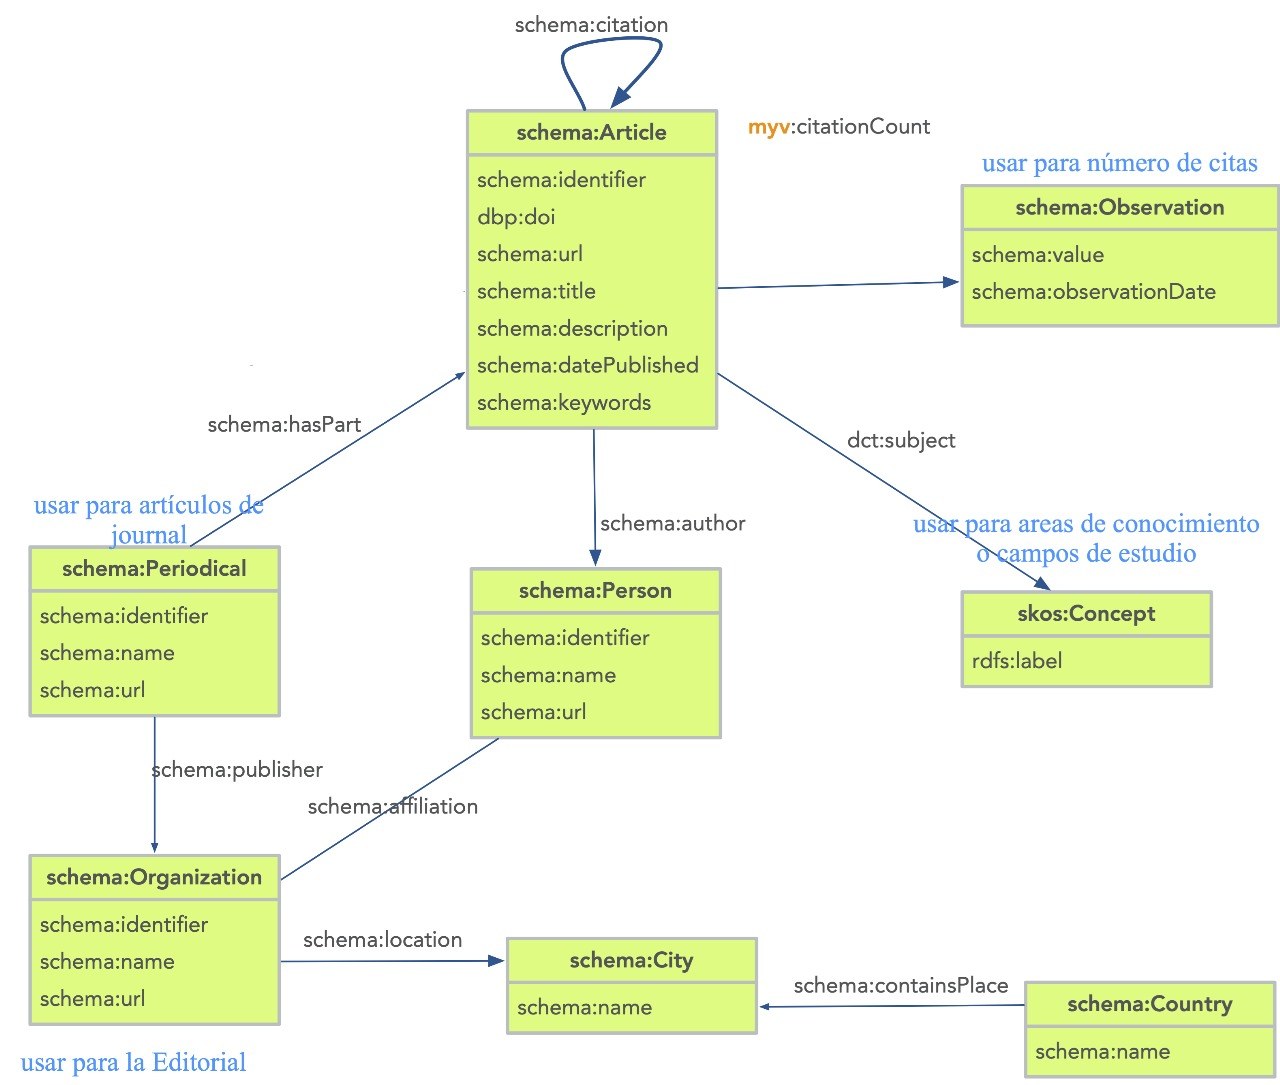

In [13]:
# Retrieve the model as the reference for transformation
from IPython.display import Image

# Specify the path to your image file
image_path = 'model.jpg'

# Display the image
Image(filename=image_path,width=500)

In [14]:
!jupyter nbconvert --to html generacion_grafo.ipynb

[NbConvertApp] Converting notebook generacion_grafo.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 583914 bytes to generacion_grafo.html
